
# The "Majority Illusion" — Reproduction of Fig. 2 (patched)

*Plots show the magnitude of the illusion in scale-free networks as a function of degree–attribute correlation* $<\rho_{kx}>$ *and for different values of degree assortativity* $<r_{kk}>$. *Each network has 10,000 nodes and degree distribution of the form* $<p(k)\sim k^{-\alpha}>$. *The fraction of active nodes in all cases is 5%.*


In [1]:

import numpy as np
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional


In [2]:

@dataclass
class Config:
    N: int = 10000
    alphas: Tuple[float, ...] = (2.1, 2.4, 3.1)
    r_by_alpha: Dict[float, Tuple[float, ...]] = None
    rho_grid: Tuple[float, ...] = tuple(np.round(np.linspace(0.0, 0.55, 50), 2))
    p_global: float = 0.05 #0.05
    kmin: int = 1
    kmax: Optional[int] = int(2*(10_000 * 8)**0.5)
    tol_r: float = 0.01
    max_rewire_steps_per_edge: float = 10 #8.0
    tol_rho: float = 0.015
    max_bias_bisection: int = 30 #24
    sample_nodes: Optional[int] = None
    trials_per_rho: int = 1
    rng_seed: int = 123

CFG = Config()
CFG.r_by_alpha = {
    2.1: (-0.35, -0.25, -0.15, -0.05),
    2.4: (-0.20, -0.10,  0.00,  0.10,  0.20),
    3.1: (-0.15, -0.05,  0.00,  0.30),
}
CFG


Config(N=10000, alphas=(2.1, 2.4, 3.1), r_by_alpha={2.1: (-0.35, -0.25, -0.15, -0.05), 2.4: (-0.2, -0.1, 0.0, 0.1, 0.2), 3.1: (-0.15, -0.05, 0.0, 0.3)}, rho_grid=(np.float64(0.0), np.float64(0.01), np.float64(0.02), np.float64(0.03), np.float64(0.04), np.float64(0.06), np.float64(0.07), np.float64(0.08), np.float64(0.09), np.float64(0.1), np.float64(0.11), np.float64(0.12), np.float64(0.13), np.float64(0.15), np.float64(0.16), np.float64(0.17), np.float64(0.18), np.float64(0.19), np.float64(0.2), np.float64(0.21), np.float64(0.22), np.float64(0.24), np.float64(0.25), np.float64(0.26), np.float64(0.27), np.float64(0.28), np.float64(0.29), np.float64(0.3), np.float64(0.31), np.float64(0.33), np.float64(0.34), np.float64(0.35), np.float64(0.36), np.float64(0.37), np.float64(0.38), np.float64(0.39), np.float64(0.4), np.float64(0.42), np.float64(0.43), np.float64(0.44), np.float64(0.45), np.float64(0.46), np.float64(0.47), np.float64(0.48), np.float64(0.49), np.float64(0.51), np.float64(0.5

In [3]:

def sample_powerlaw_degrees(N: int, alpha: float, kmin: int, kmax: int, rng):
    ks = np.arange(kmin, kmax + 1, dtype=int)
    pk = ks.astype(float) ** (-alpha); pk /= pk.sum()
    deg = rng.choice(ks, size=N, replace=True, p=pk)
    if deg.sum() % 2 == 1:
        i = rng.integers(0, N); deg[i] = min(deg[i]+1, kmax)
    return deg

def config_graph_from_seq(deg: np.ndarray, seed: int = 42) -> nx.Graph:
    Gm = nx.configuration_model(deg, seed=seed)
    G = nx.Graph(Gm); G.remove_edges_from(nx.selfloop_edges(G))
    return G


In [4]:

def _assort_constants(G: nx.Graph, deg: Dict[int,int] = None):
    if deg is None: deg = dict(G.degree())
    M = G.number_of_edges()
    dvals = np.array(list(deg.values()), dtype=float)
    B = 0.5 * np.sum(dvals**2)
    C = 0.5 * np.sum(dvals**3)
    A = 0
    for u, v in G.edges():
        A += deg[u]*deg[v]
    denom = (C/M) - (B/M)**2
    return A, B, C, M, denom, deg

def assort_from_A(A, B, C, M):
    return (A/M - (B/M)**2) / (C/M - (B/M)**2)


In [5]:

def rewire_to_rkk(G: nx.Graph, r_target: float, tol: float, max_rewire_steps_per_edge: float,
                  seed: int = 42, verbose: bool = False) -> float:
    rng = np.random.default_rng(seed)
    A, B, C, M, denom, deg = _assort_constants(G)
    if denom <= 0:
        return nx.degree_assortativity_coefficient(G)
    r = assort_from_A(A, B, C, M)
    edges: List[Tuple[int,int]] = list(G.edges())
    adj = {u: set(G.neighbors(u)) for u in G.nodes()}
    steps = int(max_rewire_steps_per_edge * M)
    direction = 1 if r_target > r else -1
    no_improve = 0
    for t in range(steps):
        i = rng.integers(len(edges)); j = rng.integers(len(edges))
        if i == j: continue
        a,b = edges[i]; c,d = edges[j]
        if len({a,b,c,d}) < 4: continue
        valid1 = (c not in adj[a]) and (d not in adj[b]) and (a!=c) and (b!=d)
        valid2 = (d not in adj[a]) and (c not in adj[b]) and (a!=d) and (b!=c)
        if not (valid1 or valid2): continue
        ka,kb,kc,kd = deg[a],deg[b],deg[c],deg[d]
        current = ka*kb + kc*kd
        delta1 = (ka*kc + kb*kd) - current
        delta2 = (ka*kd + kb*kc) - current
        cand=[]
        if valid1: cand.append(("ac_bd", delta1))
        if valid2: cand.append(("ad_bc", delta2))
        if not cand: continue
        label, delta = max(cand, key=lambda x:x[1]) if direction>0 else min(cand, key=lambda x:x[1])
        if (direction>0 and delta<=0) or (direction<0 and delta>=0):
            no_improve += 1
            if no_improve > 5000:
                r = assort_from_A(A,B,C,M)
                direction = 1 if r_target>r else -1
                no_improve = 0
            continue
        G.remove_edge(a,b); adj[a].remove(b); adj[b].remove(a)
        G.remove_edge(c,d); adj[c].remove(d); adj[d].remove(c)
        if label=="ac_bd":
            G.add_edge(a,c); adj[a].add(c); adj[c].add(a)
            G.add_edge(b,d); adj[b].add(d); adj[d].add(b)
            edges[i]=(a,c); edges[j]=(b,d)
        else:
            G.add_edge(a,d); adj[a].add(d); adj[d].add(a)
            G.add_edge(b,c); adj[b].add(c); adj[c].add(b)
            edges[i]=(a,d); edges[j]=(b,c)
        A += delta
        r = assort_from_A(A,B,C,M)
        direction = 1 if r_target>r else -1
        if verbose and (t % (M//2 + 1) == 0):
            print(f"[{t}/{steps}] r≈{r:.4f} (target {r_target:+.2f})")
        if abs(r - r_target) <= tol: break
    return r


In [6]:

def assign_attribute_with_rho_and_p(k: np.ndarray, rho_target: float, p: float,
                                    tol: float, max_iter: int, rng):
    N = len(k); m = int(round(p*N))
    lo, hi = -8.0, 8.0
    x_best, rho_best = None, -1.0
    for _ in range(max_iter):
        beta = 0.5*(lo+hi)
        w = k.astype(float)**beta
        w = np.nan_to_num(w, nan=0.0, posinf=0.0, neginf=0.0)
        if w.sum()==0: w = np.ones_like(w)
        w = w / w.sum()
        idx = rng.choice(N, size=m, replace=False, p=w)
        x = np.zeros(N, dtype=np.int8); x[idx]=1
        rho = np.corrcoef(k, x)[0,1]
        x_best, rho_best = x, rho
        if abs(rho - rho_target) <= tol: break
        if rho < rho_target: lo = beta
        else: hi = beta
    return x_best, rho_best


In [7]:

def prob_majority_in_gcc(G: nx.Graph, x: np.ndarray, sample_nodes, rng):
    GCC = max(nx.connected_components(G), key=len)
    H = G.subgraph(GCC).copy()
    nodes = np.array(list(H.nodes()), dtype=int)
    xH = x[nodes]
    A = nx.to_scipy_sparse_array(H, format="csr", dtype=np.int8)
    deg = np.asarray(A.sum(1)).ravel()
    ok = deg > 0
    if sample_nodes is not None and sample_nodes < ok.sum():
        idx = np.where(ok)[0]
        choose = rng.choice(idx, size=sample_nodes, replace=False)
        mask = np.zeros_like(ok, dtype=bool); mask[choose] = True
        ok = mask
    counts = (A @ xH)
    return (counts[ok] > 0.5*deg[ok]).mean()


In [8]:

def run_panel(alpha, r_targets, cfg):
    rng = np.random.default_rng(cfg.rng_seed)
    results = {}; r_measured = {}
    # structural cutoff already set in cfg.kmax
    for r_target in r_targets:
        deg = sample_powerlaw_degrees(cfg.N, alpha, cfg.kmin, cfg.kmax, rng)
        G = config_graph_from_seq(deg, seed=cfg.rng_seed)
        r_real = rewire_to_rkk(G, r_target, cfg.tol_r, cfg.max_rewire_steps_per_edge, seed=cfg.rng_seed, verbose=False)
        r_measured[r_target] = r_real
        k = np.array([d for _, d in sorted(G.degree(), key=lambda x: x[0])], dtype=int)
        rhos, vals = [], []
        for rho_target in cfg.rho_grid:
            rv, pv = [], []
            for _ in range(cfg.trials_per_rho):
                x, rho_real = assign_attribute_with_rho_and_p(k, rho_target, cfg.p_global, cfg.tol_rho, cfg.max_bias_bisection, rng)
                p = prob_majority_in_gcc(G, x, cfg.sample_nodes, rng)
                rv.append(rho_real); pv.append(p)
            rhos.append(float(np.mean(rv))); vals.append(float(np.mean(pv)))
        order = np.argsort(rhos)
        results[r_target] = (np.array(rhos)[order], np.array(vals)[order])
    return results, r_measured


In [9]:

def run_all_panels(cfg):
    results_by_alpha, r_meas_by_alpha = {}, {}
    for a in cfg.alphas:
        res, r_meas = run_panel(a, cfg.r_by_alpha[a], cfg)
        results_by_alpha[a] = res; r_meas_by_alpha[a] = r_meas
    return results_by_alpha, r_meas_by_alpha
    
results_by_alpha, r_meas_by_alpha = run_all_panels(CFG)



C:\Users\dcaceres\AppData\Local\Temp\ipykernel_21236\277007760.py:8: RuntimeWarning: divide by zero encountered in power
  w = k.astype(float)**beta


In [10]:

# CFG.sample_nodes = 4000
# CFG.max_rewire_steps_per_edge = 4.0

results_by_alpha, r_meas_by_alpha = run_all_panels(CFG)


C:\Users\dcaceres\AppData\Local\Temp\ipykernel_21236\277007760.py:8: RuntimeWarning: divide by zero encountered in power
  w = k.astype(float)**beta


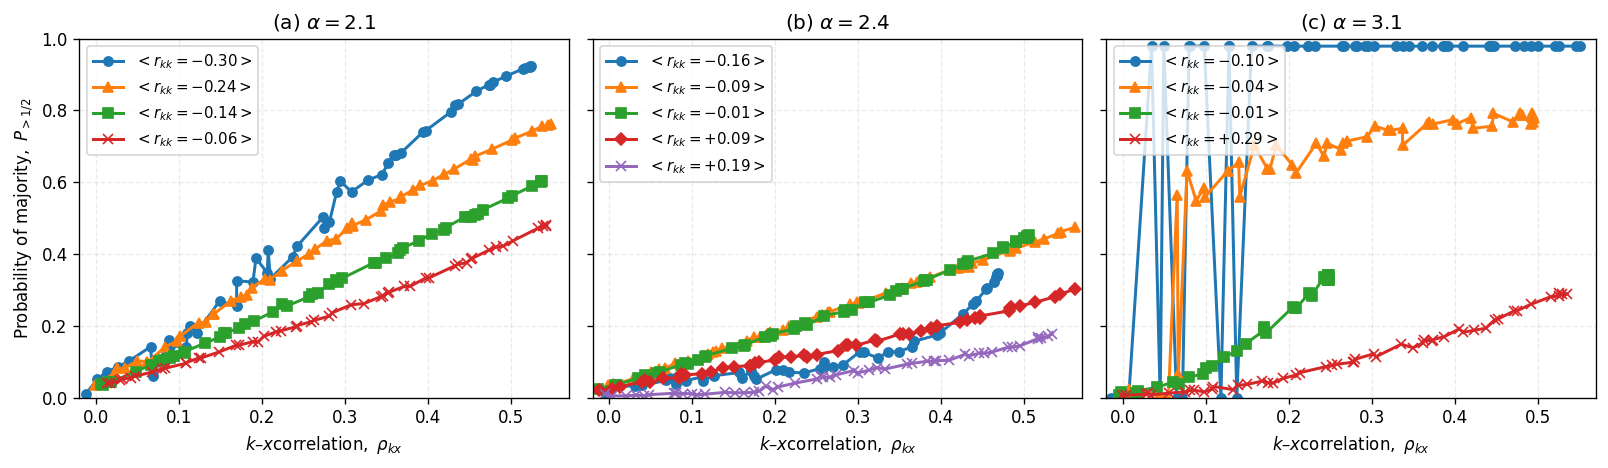

In [11]:

def plot_three_panels(results_by_alpha, r_meas_by_alpha, cfg):
    fig, axes = plt.subplots(1, 3, figsize=(13.5,4), dpi=120, sharex=True, sharey=True)
    marker_sets = {2.1:["o","^","s","x"], 2.4:["o","^","s","D","x"], 3.1:["o","^","s","x"]}
    titles = {2.1:"(a) $\\alpha=2.1$", 2.4:"(b) $\\alpha=2.4$", 3.1:"(c) $\\alpha=3.1$"}
    for ax, a in zip(axes, cfg.alphas):
        markers = marker_sets[a]
        for i, r_target in enumerate(cfg.r_by_alpha[a]):
            rhos, vals = results_by_alpha[a][r_target]
            lab = rf"$<r_{{kk}}={r_meas_by_alpha[a][r_target]:+.2f}>$"
            ax.plot(rhos, vals, marker=markers[i%len(markers)], linewidth=1.8, markersize=5.5, label=lab)
        ax.set_title(titles[a]); ax.grid(True, alpha=.25, linestyle="--")
        ax.set_xlim(min(cfg.rho_grid)-0.02, max(cfg.rho_grid)+0.02); ax.set_ylim(0,1.0)
        ax.set_xlabel(r"$k\text{–}x \mathrm{correlation},\ \rho_{kx}$")
        

        if a==2.1: ax.set_ylabel(r"$\mathrm{Probability\ of\ majority},\ P_{>1/2}$")
        ax.legend(frameon=True, loc="upper left", fontsize=9)
    plt.tight_layout(); plt.show()
plot_three_panels(results_by_alpha, r_meas_by_alpha, CFG)
